# CNN model for Histopathologic Cancer Detection

This project is related to the Keggle competition "Histopathologic Cancer Detection". All information about the dataset and the competion can be found here: https://www.kaggle.com/c/histopathologic-cancer-detection/overview.

The objective is to create an algorithm to identify metastatic cancer in small image patches (96x96) taken from larger digital pathology scans.

The data contains 220025 training images and 57458 test images.

Below is one example of these images:


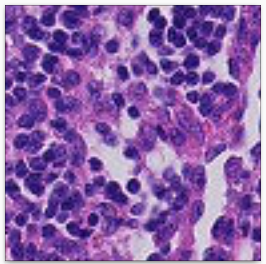

--------
Exploratory data analysis
-----------

In [7]:
# installing libraries

#%pip install pandas
#%pip install numpy
#!pip install matplotlib
#%pip install -U scikit-learn
#%pip install seaborn
#%pip install tensorflow

In [8]:
# uploading kaggle.json file to colab folder

#! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [9]:
# download the data from kaggle API

! kaggle competitions download -c histopathologic-cancer-detection

100% 6.29G/6.31G [01:17<00:00, 114MB/s]
100% 6.31G/6.31G [01:17<00:00, 87.8MB/s]


In [10]:
# unzip the downloaded file

! unzip histopathologic-cancer-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/fa2c546059bd262cbe954dfdba24dc0d67f598b0.tif  
  inflating: train/fa2c657eff58b6802cb32843caa2fac25b67c2c9.tif  
  inflating: train/fa2c775c4457d0aeb7e57216849eef5f4e72e566.tif  
  inflating: train/fa2c77e1707c2fe7b0016e00736fb6e4b7f09488.tif  
  inflating: train/fa2ce5e802dd281bd98fcfb538e80b9c96c2b7af.tif  
  inflating: train/fa2d24e4a109d2d3a925890aaed4e0f038dfffb0.tif  
  inflating: train/fa2d7e4865aa7869d2dd85116323b8405c94f1c2.tif  
  inflating: train/fa2d8b2e4acf46e278e2e7acbc034c263d970737.tif  
  inflating: train/fa2df9148831509a181797db79eb1a7bf39593f1.tif  
  inflating: train/fa2e6db0b35484797f58005e3a6e24ca75fbca76.tif  
  inflating: train/fa2e80e84594465329bdc0c8d1b3a507275fbb4d.tif  
  inflating: train/fa2eaf8ec6267fa928a88775dc15ee25b633c537.tif  
  inflating: train/fa2ebf31ff5954570526d4835ac5368fabc1f035.tif  
  inflating: train/fa2efd2dda5235a3e397ea0dd637ea13a78f7599.tif  
  inflating: train/fa2f1d

In [11]:
# importing ibraries

from numpy.random import seed
# seed(101)

import pandas as pd
import numpy as np


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import os
# import cv2

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
from glob import glob
from skimage.io import imread
%matplotlib inline
# tf.random.set_seed(101)

In [12]:
# number of files in test and train directory

print('number of train files: ', len(os.listdir('train')))
print('number of test files: ', len(os.listdir('test')))

number of train files:  220025
number of test files:  57458


In [13]:
# using the labels in train_lables.csv to create a dataframe for the training data

df = pd.read_csv('train_labels.csv')
# shape of df
print(df.shape)
# some samples of df
df.sample(5)

(220025, 2)


,id,label
167578,b40942f8de18b215baecd71e4ce9b8f25ef0648c,0
154064,5652799b43ea6879ee8255c1f8eb7b68c13244a4,1
190222,3d48cf12f0161e01a25447041c74c33ce41142f1,0
143239,5bc0f8333dc536ab3535dc2beba7e9e2bf2dab59,1
40700,d80e7931a45aa16885fb4cd3bf141b77c3c6da75,1


0    59.5
1    40.5
Name: label, dtype: float64


([<matplotlib.patches.Wedge at 0x7d6dcf68fca0>,
 [Text(-0.32334109228524116, 1.051404079333815, 'Tumor'),
  Text(0.3233409938456856, -1.0514041096071884, 'No Tumor')])

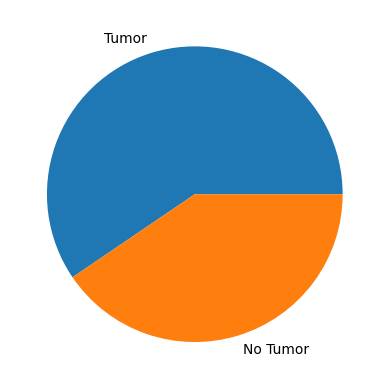

In [14]:
# percentage of Tumor (label 0) vs no tumor (label 1)
print(round(df['label'].value_counts(normalize=True) * 100, 1))

# visualizing the percentage of each class
labels = 'Tumor', 'No Tumor'
sizes = df['label'].value_counts(normalize=True) * 100

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels)


We see that around 60% of the training data are with tumor and 40% without tumor

-------------
Data Cleaning
------------

Removing 2 iamges which create errors during the training

In [15]:
df_clean = df[(df['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2') & (df['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe')]
df_clean.shape

(220023, 2)

In [16]:
# randomly selecting 10000 samples for training
df_no_tumor=df_clean[df_clean['label']==0].sample(10000,random_state=42)
df_tumor=df_clean[df_clean['label']==1].sample(10000,random_state=42)

df_tv = shuffle(pd.concat([df_no_tumor, df_tumor], axis=0).reset_index(drop=True))

In [17]:
# spliting data to train (90%) and validate (10%)

df_t, df_v = train_test_split(df_tv, test_size=0.10, random_state=101, stratify=df_tv['label'])
print(df_t.shape)
print(df_v.shape)

(18000, 2)
(2000, 2)


In [18]:
# Set the id as the index in df_clean
df_clean.set_index('id', inplace=True)

In [19]:
# Create a new folder for the sampled data to use ImageDataGenerator (for scaling)
#shutil.rmtree("samples")
os.mkdir('samples')
# folder for train samples
train_folder = os.path.join('samples', 'train_folder')
os.mkdir(train_folder)
# folder for validation samples
val_folder = os.path.join('samples', 'val_folder')
os.mkdir(val_folder)


# creating seperate folders for each class inside both training and validation folder of samples

# create new folders inside train_dir
for folder in [train_folder, val_folder]:
    w_tumor = os.path.join(folder, 'w_tumor')
    os.mkdir(w_tumor)
    w_o_tumor = os.path.join(folder, 'w_o_tumor')
    os.mkdir(w_o_tumor)

In [20]:
# copying the sampled images to their respective folders

# for traing data
for id_file in list(df_t['id']):

    source = os.path.join('train', id_file + '.tif')

    if df_clean.loc[id_file,'label'] == 0:
        dest = os.path.join(train_folder, 'w_o_tumor', id_file + '.tif')
    if df_clean.loc[id_file,'label'] == 1:
        dest = os.path.join(train_folder, 'w_tumor', id_file + '.tif')

    shutil.copyfile(source, dest)

# for validation data
for id_file in list(df_v['id']):

    source = os.path.join('train', id_file + '.tif')
    if df_clean.loc[id_file,'label'] == 0:
        dest = os.path.join(val_folder, 'w_o_tumor', id_file + '.tif')
    if df_clean.loc[id_file,'label'] == 1:
        dest = os.path.join(val_folder, 'w_tumor', id_file + '.tif')

    shutil.copyfile(source, dest)

Image scaling and generating batches used ImageDataGenerator


In [21]:
#  scale array of original image pixel values to be between [0,1] using ImageDataGenerator

datagenerator = ImageDataGenerator(rescale=1.0/255)

# taking the files form the folders and generateing batches (batch size =10)

train_g = datagenerator.flow_from_directory('samples/train_folder', target_size=(96,96), batch_size=10, class_mode='categorical')
val_g = datagenerator.flow_from_directory('samples/val_folder', target_size=(96,96), batch_size=10, class_mode='categorical')

Found 18000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


------------
CNN Model
------------

Creating a CNN model with
- input layer of 96x96x3 (RGB)
- 3x3 filter dimension (3x3 filter is chosen to reduce the computational cost)
- 3 layers of convolution filters each with 64 filters
- pool dimension of 2x2 (to reduce computational cost)
- dropout factor of 0.2 (for regularization)
- relu activation for inner layers and softmax for output layer (classification)

In [22]:
filter_dim = (3,3)
filter_sizes = [64,64,64]
pool_dim= (2,2)

dropout = 0.2


model = Sequential()

# repeat 3 times for each filter layer
for filter_size in filter_sizes:
  model.add(Conv2D(filter_size, filter_dim, activation = 'relu', input_shape = (96, 96, 3)))
  model.add(Conv2D(filter_size, filter_dim, activation = 'relu'))
  model.add(Conv2D(filter_size, filter_dim, activation = 'relu'))
  model.add(MaxPooling2D(pool_size = pool_dim))
  model.add(Dropout(dropout))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout))
model.add(Dense(2, activation = "softmax"))

# print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 64)        36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 45, 45, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 45, 45, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 43, 43, 64)        36928     
                                                        

In [23]:
# compile the model with Adam (learning rate of 0.0001) and accuracy as metric
model.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
# fitting the model for 20 epochs
result = model.fit_generator(train_g, steps_per_epoch=len(df_t)/10, validation_data=val_g, validation_steps=len(df_v)/10, epochs=20)

<ipython-input-24-b3794ec3d25a>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  result = model.fit_generator(train_g, steps_per_epoch=len(df_t)/10, validation_data=val_g, validation_steps=len(df_v)/10, epochs=20)


Epoch 1/20
1800/1800 [==============================] - 68s 31ms/step - loss: 0.5502 - accuracy: 0.7128 - val_loss: 0.5125 - val_accuracy: 0.7700
Epoch 2/20
1800/1800 [==============================] - 55s 31ms/step - loss: 0.4752 - accuracy: 0.7845 - val_loss: 0.4501 - val_accuracy: 0.7850
Epoch 3/20
1800/1800 [==============================] - 55s 30ms/step - loss: 0.4444 - accuracy: 0.7969 - val_loss: 0.4167 - val_accuracy: 0.8075
Epoch 4/20
1800/1800 [==============================] - 53s 29ms/step - loss: 0.4208 - accuracy: 0.8122 - val_loss: 0.3954 - val_accuracy: 0.8180
Epoch 5/20
1800/1800 [==============================] - 56s 31ms/step - loss: 0.3984 - accuracy: 0.8248 - val_loss: 0.3872 - val_accuracy: 0.8260
Epoch 6/20
1800/1800 [==============================] - 55s 30ms/step - loss: 0.3746 - accuracy: 0.8348 - val_loss: 0.4160 - val_accuracy: 0.7935
Epoch 7/20
1800/1800 [==============================] - 54s 30ms/step - loss: 0.3595 - accuracy: 0.8433 - val_loss: 0.3353 -

After 20 epochs the traing accuracy is 0.914 and the validation accuracy is 0.897

<Figure size 640x480 with 0 Axes>

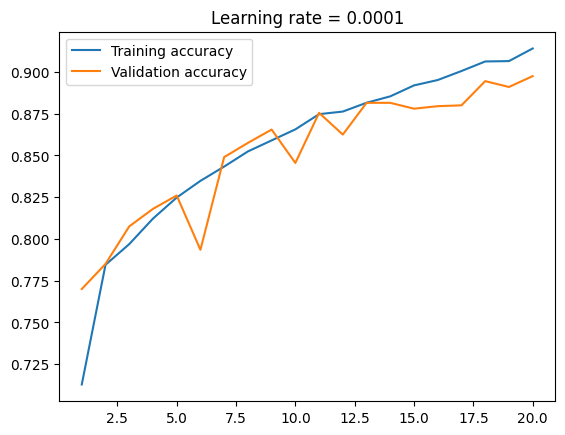

<Figure size 640x480 with 0 Axes>

In [25]:
# plot the accuracy:

acc_t = result.history['accuracy']
acc_v = result.history['val_accuracy']

x_axis = range(1, len(acc_t) + 1)

plt.plot(x_axis, acc_t, label='Training accuracy')
plt.plot(x_axis, acc_v, label='Validation accuracy')
plt.title('Learning rate = 0.0001')
plt.legend()
plt.figure()

As we see from the graph above both training and validation accuracy are still increasing and are not yet stable after 20 epochs.

Hyperparameter tuning and model architecture modification
------------

firstly, I increase the leraning rate to see if the accuracy reaches stabilization after 20 epochs or not: increasing the learing rate form 0.0001 to 0.0002

In [ ]:
# same model but with learning rate of 0.0002
model.compile(Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])
result2 = model.fit_generator(train_g, steps_per_epoch=len(df_t)/10, validation_data=val_g, validation_steps=len(df_v)/10, epochs=20)

Epoch 1/20


<ipython-input-42-bea38e7261de>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  result2 = model.fit_generator(train_g, steps_per_epoch=len(df_t)/10, validation_data=val_g, validation_steps=len(df_v)/10, epochs=20)


1800/1800 [==============================] - 64s 33ms/step - loss: 0.2667 - accuracy: 0.8900 - val_loss: 0.2888 - val_accuracy: 0.8775
Epoch 2/20
1800/1800 [==============================] - 59s 33ms/step - loss: 0.2616 - accuracy: 0.8922 - val_loss: 0.2958 - val_accuracy: 0.8700
Epoch 3/20
1800/1800 [==============================] - 60s 33ms/step - loss: 0.2553 - accuracy: 0.8954 - val_loss: 0.2779 - val_accuracy: 0.8760
Epoch 4/20
1800/1800 [==============================] - 58s 32ms/step - loss: 0.2424 - accuracy: 0.8970 - val_loss: 0.3402 - val_accuracy: 0.8575
Epoch 5/20
1800/1800 [==============================] - 58s 32ms/step - loss: 0.2285 - accuracy: 0.9059 - val_loss: 0.2850 - val_accuracy: 0.8690
Epoch 6/20
1800/1800 [==============================] - 61s 34ms/step - loss: 0.2191 - accuracy: 0.9078 - val_loss: 0.3842 - val_accuracy: 0.8430
Epoch 7/20
1800/1800 [==============================] - 60s 33ms/step - loss: 0.2077 - accuracy: 0.9169 - val_loss: 0.2862 - val_accura

at epoch 20: training accuracy is 0.966 (significantly improved) but the validation accuracy remains at 0.881

<Figure size 640x480 with 0 Axes>

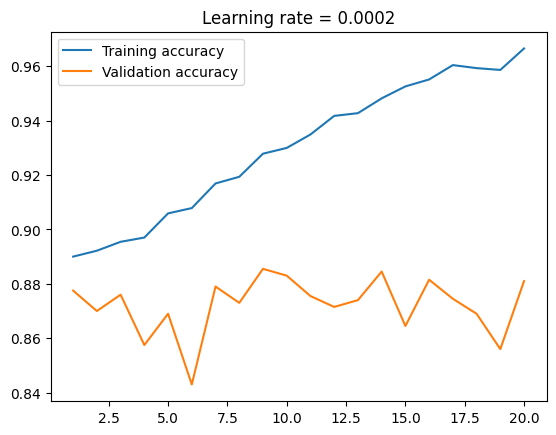

<Figure size 640x480 with 0 Axes>

In [ ]:
# plot the accuracy:

acc_t = result2.history['accuracy']
acc_v = result2.history['val_accuracy']

x_axis = range(1, len(acc_t) + 1)

plt.plot(x_axis, acc_t, label='Training accuracy')
plt.plot(x_axis, acc_v, label='Validation accuracy')
plt.title('Learning rate = 0.0002')
plt.legend()
plt.figure()

The graph above shows that, even though the training accuracy significantly improved (compared with the leraing rate of 0.001) the validation accuracy does not increase

For the next trial, I modify the model architecture by increasing the size of the 3rd filter to 128 (from 64) and I increase the number of epochs to 30 and I use agian the learing rate of 0.0001

In [ ]:
filter_dim = (3,3)
filter_sizes = [64,64,128]
pool_dim= (2,2)

dropout = 0.2


model2 = Sequential()

# repeat 3 times for each filter layer
for filter_size in filter_sizes:
  model2.add(Conv2D(filter_size, filter_dim, activation = 'relu', input_shape = (96, 96, 3)))
  model2.add(Conv2D(filter_size, filter_dim, activation = 'relu'))
  model2.add(Conv2D(filter_size, filter_dim, activation = 'relu'))
  model2.add(MaxPooling2D(pool_size = pool_dim))
  model2.add(Dropout(dropout))

model2.add(Flatten())
model2.add(Dense(256, activation = "relu"))
model2.add(Dropout(dropout))
model2.add(Dense(2, activation = "softmax"))

# print model summary
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 94, 94, 64)        1792      
                                                                 
 conv2d_19 (Conv2D)          (None, 92, 92, 64)        36928     
                                                                 
 conv2d_20 (Conv2D)          (None, 90, 90, 64)        36928     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 45, 45, 64)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 43, 43, 64)        36928     
                                                      

In [ ]:
# epochs: 30 and learning rate=0.0001
model2.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
result3 = model2.fit_generator(train_g, steps_per_epoch=len(df_t)/10, validation_data=val_g, validation_steps=len(df_v)/10, epochs=30)

Epoch 1/30


<ipython-input-45-42ccf312812c>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  result3 = model2.fit_generator(train_g, steps_per_epoch=len(df_t)/10, validation_data=val_g, validation_steps=len(df_v)/10, epochs=30)


1800/1800 [==============================] - 66s 34ms/step - loss: 0.5317 - accuracy: 0.7397 - val_loss: 0.4651 - val_accuracy: 0.7815
Epoch 2/30
1800/1800 [==============================] - 57s 32ms/step - loss: 0.4729 - accuracy: 0.7808 - val_loss: 0.4347 - val_accuracy: 0.7940
Epoch 3/30
1800/1800 [==============================] - 59s 33ms/step - loss: 0.4423 - accuracy: 0.7990 - val_loss: 0.4066 - val_accuracy: 0.8150
Epoch 4/30
1800/1800 [==============================] - 59s 33ms/step - loss: 0.4187 - accuracy: 0.8133 - val_loss: 0.4291 - val_accuracy: 0.8055
Epoch 5/30
1800/1800 [==============================] - 56s 31ms/step - loss: 0.3900 - accuracy: 0.8284 - val_loss: 0.3681 - val_accuracy: 0.8305
Epoch 6/30
1800/1800 [==============================] - 61s 34ms/step - loss: 0.3772 - accuracy: 0.8374 - val_loss: 0.3533 - val_accuracy: 0.8330
Epoch 7/30
1800/1800 [==============================] - 59s 33ms/step - loss: 0.3577 - accuracy: 0.8447 - val_loss: 0.3635 - val_accura

at epoch 30: the training accuracy is 0.951 and the validation accuracy is 0.883

<Figure size 640x480 with 0 Axes>

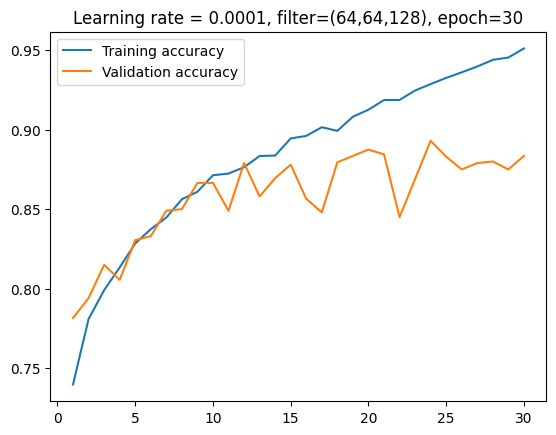

<Figure size 640x480 with 0 Axes>

In [ ]:
# plot the accuracy:

acc_t = result3.history['accuracy']
acc_v = result3.history['val_accuracy']

x_axis = range(1, len(acc_t) + 1)

plt.plot(x_axis, acc_t, label='Training accuracy')
plt.plot(x_axis, acc_v, label='Validation accuracy')
plt.title('Learning rate = 0.0001, filter=(64,64,128), epoch=30')
plt.legend()
plt.figure()

The graph above shows that even if the training accuracy continues to increase the validation accuracy remains at the level of 0.88 which might indicate an overfitting issue

to reduce the overfitting issue I increase the dropout factor to 0.3 (from 0.2) and I use again the filter size of [64,64,64]

In [ ]:
filter_dim = (3,3)
filter_sizes = [64,64,64]
pool_dim= (2,2)

dropout = 0.3


model3 = Sequential()

# repeat 3 times for each filter layer
for filter_size in filter_sizes:
  model3.add(Conv2D(filter_size, filter_dim, activation = 'relu', input_shape = (96, 96, 3)))
  model3.add(Conv2D(filter_size, filter_dim, activation = 'relu'))
  model3.add(Conv2D(filter_size, filter_dim, activation = 'relu'))
  model3.add(MaxPooling2D(pool_size = pool_dim))
  model3.add(Dropout(dropout))

model3.add(Flatten())
model3.add(Dense(256, activation = "relu"))
model3.add(Dropout(dropout))
model3.add(Dense(2, activation = "softmax"))

# print model summary
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 94, 94, 64)        1792      
                                                                 
 conv2d_28 (Conv2D)          (None, 92, 92, 64)        36928     
                                                                 
 conv2d_29 (Conv2D)          (None, 90, 90, 64)        36928     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 45, 45, 64)        0         
                                                                 
 conv2d_30 (Conv2D)          (None, 43, 43, 64)        36928     
                                                      

In [ ]:
# learning rate of 0.0001 and 20 epochs
model3.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
result4 = model3.fit_generator(train_g, steps_per_epoch=len(df_t)/10, validation_data=val_g, validation_steps=len(df_v)/10, epochs=20)

Epoch 1/20


<ipython-input-49-a570011d9a48>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  result4 = model3.fit_generator(train_g, steps_per_epoch=len(df_t)/10, validation_data=val_g, validation_steps=len(df_v)/10, epochs=20)


1800/1800 [==============================] - 61s 32ms/step - loss: 0.5304 - accuracy: 0.7323 - val_loss: 0.4825 - val_accuracy: 0.7695
Epoch 2/20
1800/1800 [==============================] - 54s 30ms/step - loss: 0.4752 - accuracy: 0.7843 - val_loss: 0.4834 - val_accuracy: 0.7735
Epoch 3/20
1800/1800 [==============================] - 54s 30ms/step - loss: 0.4489 - accuracy: 0.7972 - val_loss: 0.4111 - val_accuracy: 0.8110
Epoch 4/20
1800/1800 [==============================] - 56s 31ms/step - loss: 0.4268 - accuracy: 0.8120 - val_loss: 0.3951 - val_accuracy: 0.8265
Epoch 5/20
1800/1800 [==============================] - 53s 30ms/step - loss: 0.4072 - accuracy: 0.8205 - val_loss: 0.3925 - val_accuracy: 0.8200
Epoch 6/20
1800/1800 [==============================] - 53s 30ms/step - loss: 0.3857 - accuracy: 0.8281 - val_loss: 0.3781 - val_accuracy: 0.8270
Epoch 7/20
1800/1800 [==============================] - 55s 30ms/step - loss: 0.3666 - accuracy: 0.8391 - val_loss: 0.3485 - val_accura

at epoch 20: the training accuracy is 0.899 and the validation accuracy is 0.867, which did not improve significantly compred to the previous models

<Figure size 640x480 with 0 Axes>

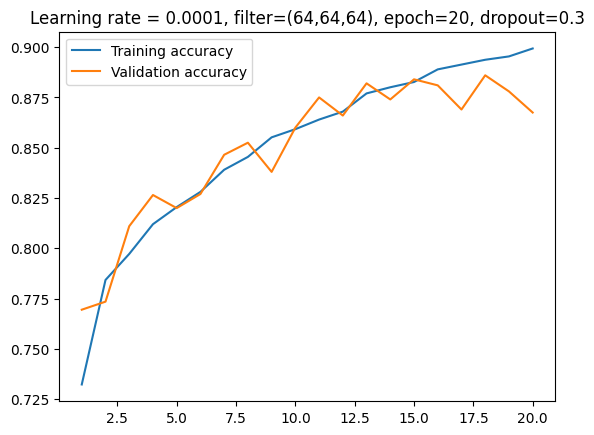

<Figure size 640x480 with 0 Axes>

In [ ]:
# plot the accuracy:

acc_t = result4.history['accuracy']
acc_v = result4.history['val_accuracy']

x_axis = range(1, len(acc_t) + 1)

plt.plot(x_axis, acc_t, label='Training accuracy')
plt.plot(x_axis, acc_v, label='Validation accuracy')
plt.title('Learning rate = 0.0001, filter=(64,64,64), epoch=20, dropout=0.3')
plt.legend()
plt.figure()

**Model selction:**
Based on the results above, none of the hyperparameter tunings and modified architectures significantly improved the original model, therefore I choose the very first model for the prediction on the test dataset

-------------
Prediction
-------------

In [26]:
# create a folder for test images

os.mkdir('test_folder')
# create test_images inside test_dir
test_images = os.path.join('test_folder', 'test_images')
os.mkdir(test_images)

In [27]:
# Transfer the test images into the newly creatred folder
for image in os.listdir('test'):
    source = os.path.join('test', image)
    dest = os.path.join(test_images, image)
    shutil.copyfile(source, dest)

In [28]:
# taking the files form the folder
test_g = datagenerator.flow_from_directory('test_folder', target_size=(96,96), batch_size=1, class_mode='categorical',shuffle=False)

Found 57458 images belonging to 1 classes.


In [29]:
# prediction for test images
pred = model.predict_generator(test_g, steps=57458, verbose=1)

<ipython-input-29-f2163206daf3>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = model.predict_generator(test_g, steps=57458, verbose=1)


57458/57458 [==============================] - 274s 5ms/step


In [30]:
df_pred = pd.DataFrame(pred, columns=['w_o_tissue', 'w_tissue'])
df_pred['file_names'] = test_g.filenames

df_pred.head()

,w_o_tissue,w_tissue,file_names
0,0.000110,0.999890,test_images/00006537328c33e284c973d7b39d340809...
1,0.169513,0.830487,test_images/0000ec92553fda4ce39889f9226ace43ca...
2,0.001168,0.998832,test_images/00024a6dee61f12f7856b0fc6be20bc7a4...
3,0.990671,0.009329,test_images/000253dfaa0be9d0d100283b22284ab2f6...
4,0.998490,0.001510,test_images/000270442cc15af719583a8172c87cd2bd...


-------------
Submission file
------------

In [31]:
# a function to extracting id number from the file-names
def extract_id(x):
    a = x.split('/')
    b = a[1].split('.')
    extracted_id = b[0]
    return extracted_id

df_pred['id'] = df_pred['file_names'].apply(extract_id)
df_pred.head()

,w_o_tissue,w_tissue,file_names,id
0,0.000110,0.999890,test_images/00006537328c33e284c973d7b39d340809...,00006537328c33e284c973d7b39d340809f7271b
1,0.169513,0.830487,test_images/0000ec92553fda4ce39889f9226ace43ca...,0000ec92553fda4ce39889f9226ace43cae3364e
2,0.001168,0.998832,test_images/00024a6dee61f12f7856b0fc6be20bc7a4...,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2
3,0.990671,0.009329,test_images/000253dfaa0be9d0d100283b22284ab2f6...,000253dfaa0be9d0d100283b22284ab2f6b643f6
4,0.998490,0.001510,test_images/000270442cc15af719583a8172c87cd2bd...,000270442cc15af719583a8172c87cd2bd9c7746


In [32]:
y_pred = df_pred['w_tissue']
image_id = df_pred['id']

submission = pd.DataFrame({'id':image_id, 'label':y_pred}).set_index('id')

submission.to_csv('submission.csv', columns=['label'])
submission.head()

,label
id,
00006537328c33e284c973d7b39d340809f7271b,0.999890
0000ec92553fda4ce39889f9226ace43cae3364e,0.830487
00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0.998832
000253dfaa0be9d0d100283b22284ab2f6b643f6,0.009329
000270442cc15af719583a8172c87cd2bd9c7746,0.001510


----------------------
Conclusion
-----------------------

| Model | learning rate | conv. layers dimensions | # epochs | dropout factor | train accu. | valid accu.|
| --- | --- | --- | --- |--- | --- |--- |
| 1| 0.0001| [64,64,64] | 20 |0.2 | 0.914 | 0.897 |
| 2| 0.0002| [64,64,64] | 20 |0.2 | 0.966 | 0.881 |
| 3| 0.0001| [64,64,128] | 30 |0.2 | 0.951 | 0.883 |
| 4| 0.0001| [64,64,64] | 20 |0.3 | 0.899 | 0.867 |

Above is a table comparison of different models.

Based on these results I decided to predict the test images using the first model. Below is the result of the submission:

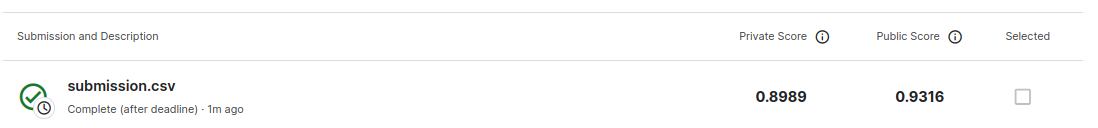

Unfortunately, the hyperparameter tuning and the model architectures that I have tested did not significantly improve the validation acuuracy compared to the first model. I should note that, due to the computational time needed, I used only 10000 training images and one can improve the accuracy of hte model by increasing the number of training samples as well as trying with lower leraning rates and increased number of epochs.

